In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
from matplotlib.animation import FuncAnimation
import math
from IPython.display import display, Markdown
import torch
from scipy.integrate import solve_ivp
%matplotlib widget

## Lorenz equation

$$
\begin{aligned}
\dot{x} & = \sigma(y-x) \\
\dot{y} & = \rho x - y - xz \\
\dot{z} & = -\beta z + xy
\end{aligned}
$$

In [34]:
def lorenz_equation(t, xyz, sigma=10, p=28, beta=8 / 3):
    """calculation of the derivative of the lorenz equantion for one time step

    Args:
        xyz (np.array): input points of shape (n, 3) where n is the number of points
        sigma (int, optional): Defaults to 10.
        p (int, optional):  Defaults to 38.
        beta (float, optional): Defaults to 8/3.

    Returns:
        np.array: dx dy and dz for given points. Shape (n, 3)
    """
    x = xyz[0]
    y = xyz[1]
    z = xyz[2]

    dx = sigma * (y - x)
    dy = x * (p - z) - y
    dz = x * y - beta * z

    return np.array([dx, dy, dz], float)

def euler(start_point: np.array, n_steps: int, dt=0.01):

    xyz = np.empty((start_point.shape[0], n_steps + 1))
    xyz[:, 0] = start_point

    dxyz = np.empty((start_point.shape[0], n_steps))

    for i in range(n_steps):
        dt_xyz = lorenz_equation(None, xyz[:, i])
        dxyz[:, i] = dt_xyz
        xyz[:, i + 1] = xyz[:, i] + dt_xyz * dt

    return xyz[:, :-1], dxyz

def integrate(start_point: np.array, t_end: int, dt=0.01, method: str="rk45"):
    """Calculate the points trajectory of the lorenz equation complimented with its derivatives by using Eulers method.

    Args:
        start_points (np.array): matrix of start_points with shape nx3
        n_steps (int): number of discrete timesteps
        dt (float, optional): time interval. Defaults to 0.01.
        method (str, optional): choose between rk45 or euler as integration method. Default to rk45

    Returns:
        tuple: returns a tuple of the trajectory points matrix of shape t+1xnx3 and the derivative matrix of txnx3
    """
    if method == "rk45":
        # get xyz positions
        sol = solve_ivp(lorenz_equation, [0, t_end], start_point, t_eval=np.arange(0, t_end, dt))

        dxyz = lorenz_equation(None, sol.y)

        return sol.y, dxyz, sol.t
    elif method == "euler":
        n_steps = t_end / dt

        xyz, dxyz = euler(start_point, int(n_steps), dt)

        return xyz, dxyz, np.arange(0, t_end, dt)
    else:
        print("Wrong interpreter: 'rk45' or 'euler' only")
        return


# def create_lorenz_traj(start_points: np.array, n_steps: int, dt=0.01, method: str="rk45"):
    

#     if method == "euler":
#         xyz = np.empty((n_steps + 1, start_points.shape[0], start_points.shape[1]))
#         xyz[0] = start_points

#         dxyz = np.empty((n_steps, start_points.shape[0], start_points.shape[1]))

#         for i in range(n_steps):
#             dt_xyz = lorenz_equation(xyz[i])
#             dxyz[i] = dt_xyz
#             xyz[i + 1] = xyz[i] + dt_xyz * dt

#         return xyz[:-1], dxyz
    
#     sol = solve_ivp(lorenz_equation, [0, 100], start_points[0], t_eval=np.arange(0, 100, dt))

#     return sol

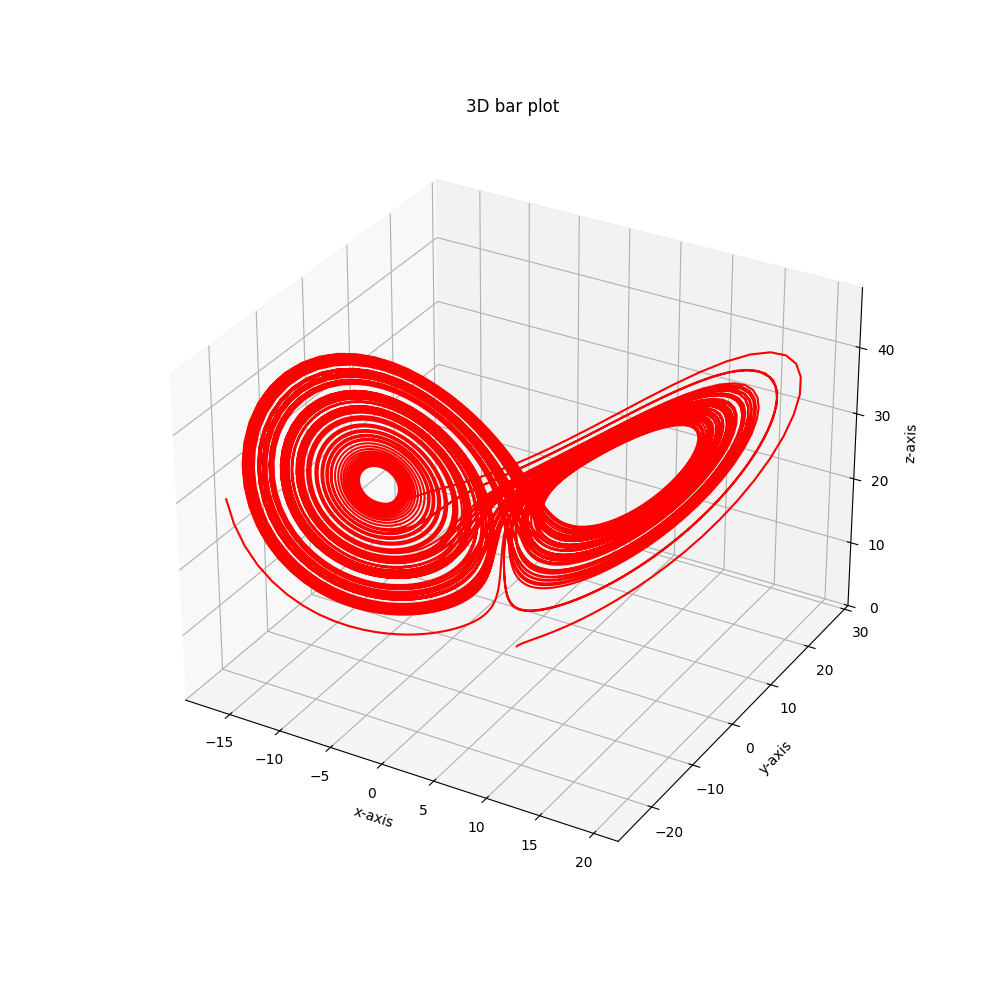

In [35]:
n_steps = 10000
start_point = np.array([1, 1, 1])

xyz, _, t = integrate(start_point, 100)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection="3d")
line = ax.plot(xyz[0], xyz[1], xyz[2], color="r")[0]

ax.set_title("3D bar plot")
ax.set_xlabel("x-axis")
ax.set_ylabel("y-axis")
ax.set_zlabel("z-axis")


def animate(i):
    line.set_data_3d(xyz[:, :i])  # update the data.
    line.set(alpha=0.5, color="r")
    return line


ani = FuncAnimation(fig, animate, n_steps, interval=10, repeat=True)

plt.show()

In [36]:
plt.close()

## Create dataset

In [110]:
t_end = 250
dt = 0.001

start_point = np.random.uniform(low=-20, high=20, size=(3))
start_point = np.array([-8,7,27])

xyz, dxyz, t = integrate(start_point, t_end, dt=dt, method="euler")
xyz.shape, dxyz.shape, t.shape

((3, 250000), (3, 250000), (250000,))

## Feature expansion

In [111]:
# feature expansion

def calc_expansion_dim(degree: int, space_dim: int = 3):
    """Calculates the dimension after expansion

    Args:
        degree (int): max degree of the expansion
        space_dim (int, optional): The spatial dimension of the Differential equation (Lorenz equation has 3 dimensions). Defaults to 3.

    Returns:
        int: Size of the expanded dimension
    """
    dim = 1

    if degree >= 1:
        dim += space_dim

    if degree >= 2:
        for d in range(degree + 1)[2:]:
            dim += math.comb(space_dim + d - 1, d)

    return dim


def get_expansion_indices(exp_dim: int, space_dim: int):
    idx = [range(space_dim) for _ in range(exp_dim)]

    idx = np.array(np.meshgrid(*idx)).T.reshape(-1, exp_dim).tolist()

    idx = np.unique([sorted(i) for i in idx], axis=0)

    return idx


def poly_expansion(X: np.array, max_deg=3):
    """A plynomial expansion of the input data up to max_exp

    Args:
        X (np.array): Trajectory data over time of shape txnx3 where t is the number of timesteps and n the number of start points
        max_deg (int, optional): Degree of the maximum expansion. Defaults to 3.

    Returns:
        np.array: The polynomial expanded input matrix of shape ...
    """
    space_dim, t = X.shape  # (time, #samples, 3) (3, time)

    X_poly = np.empty((calc_expansion_dim(max_deg), t))

    X_poly[0] = 1
    X_poly[1:4] = X

    idx = [[-1],[0],[1],[2]]

    if max_deg >= 2:
        col_idx = 4
        for d in range(max_deg+1)[2:]:
            #print(d)
            comb_idx = get_expansion_indices(d, 3)
            idx += comb_idx.tolist()
            len_exp = len(comb_idx)

            products = np.stack([np.prod([X[i] for i in indices], axis=0) for indices in comb_idx], axis=0)

            X_poly[col_idx : col_idx + len_exp] = products
            col_idx += len_exp

    return X_poly, idx

In [112]:
X_poly, idx = poly_expansion(xyz, max_deg=5)
X_poly.shape

(56, 250000)

## SINDy Model

In [149]:
class sindy_model(torch.nn.Module):
    def __init__(self, poly_dim: int, space_dim: int=3, sparsity_factor: float=1):
        super(sindy_model, self).__init__()
        self.linear = torch.nn.Linear(poly_dim, space_dim, bias=False)
        self.sparsity_factor = sparsity_factor

    def forward(self, X):
        # X = poly_X
        out = self.linear(X)
        return out
    
    def run(self, X):
        with torch.no_grad():
            out = self.linear(X).detach().numpy().T
        return out
    
    # thetaX: t x p x poly_dim
    # X: t x p x dim
    # xi: poly_dim x #dim


# l2 + l1
def lasso(model: sindy_model, model_out: torch.tensor, gt: torch.tensor):
    # t x p x #params
    # get three losses

    model_param = list(model.parameters())

    #l2 = np.linalg.norm(model_out - gt, )
    l2 = torch.mean(1/len(model_out) * torch.sqrt(torch.sum(torch.square(model_out - gt), axis=0)))
    l1 = model.sparsity_factor * torch.sum(torch.sum(torch.abs(model_param[0]), axis=-1) / len(model_param[0]))

    return l2 + l1, l2

In [150]:
def train(model: torch.nn.Module, X: torch.tensor, gt: torch.tensor, epochs=100, lr=0.01):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    losses = []
    for epoch in range(epochs):
        optimizer.zero_grad()

        out = model(X)

        loss, l2 = lasso(model, out, gt)
        #print(f"{epoch}: {loss},{l2}")
        losses.append(l2.item())

        loss.backward()

        optimizer.step()

    return losses


In [151]:
model = sindy_model(X_poly.shape[0], sparsity_factor=40)

X_in = torch.tensor(X_poly, dtype=torch.float32).T
gt = torch.tensor(dxyz, dtype=torch.float32).T

loss = train(model, X_in, gt, epochs=200)

In [152]:
def show_loss(loss: list):
    plt.clf()
    plt.plot(loss, label="loss")
    plt.title(f"Loss: min({round(min(loss), 3)})")
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.legend()
    plt.show()

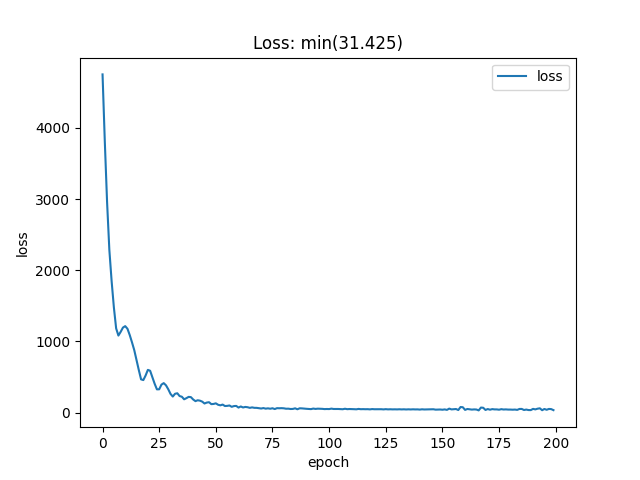

In [153]:
show_loss(loss)

In [154]:
def show_weigths(model: torch.nn.Module, idx: list, dims=["x","y","z"]):
    params = list(model.parameters())[0].detach().numpy()

    nonzeros = ~np.isclose(params, np.zeros_like(params), atol=.01)

    params = (params * nonzeros).T.tolist()

    dims += ["1"]

    table_string = "| |"

    table_string += "".join([f" d{d} |" for d in dims[:-1]])
    table_string += "\n"
    table_string += "|:----|" + "".join(["-----:|" for _ in range(len(dims[:-1]))]) + "\n"
    
    for row, indices in zip(params, idx):
        exp_term = "".join([dims[i] for i in indices])

        table_string += f"| {exp_term} | " + " | ".join([f"{round(el,3)}" if el == 0 else f"<span style='color:red;'>{round(el,3)}</span>" for el in row]) + " | \n"
        
    display(Markdown(table_string))

In [155]:
show_weigths(model, idx)

| | dx | dy | dz |
|:----|-----:|-----:|-----:|
| 1 | 0.0 | -0.0 | -0.0 | 
| x | 0.0 | -0.0 | 0.0 | 
| y | -0.0 | 0.0 | 0.0 | 
| z | 0.0 | -0.0 | 0.0 | 
| xx | -0.0 | 0.0 | -0.0 | 
| xy | -0.0 | -0.0 | -0.0 | 
| xz | 0.0 | 0.0 | 0.0 | 
| yy | -0.0 | -0.0 | -0.0 | 
| yz | 0.0 | -0.0 | 0.0 | 
| zz | 0.0 | -0.0 | -0.0 | 
| xxx | 0.0 | -0.0 | 0.0 | 
| xxy | 0.0 | -0.0 | 0.0 | 
| xxz | -0.0 | -0.0 | -0.0 | 
| xyy | 0.0 | 0.0 | 0.0 | 
| xyz | 0.0 | 0.0 | -0.0 | 
| xzz | -0.0 | 0.0 | -0.0 | 
| yyy | -0.0 | -0.0 | 0.0 | 
| yyz | -0.0 | -0.0 | 0.0 | 
| yzz | -0.0 | 0.0 | -0.0 | 
| zzz | -0.0 | -0.0 | -0.0 | 
| xxxx | 0.0 | 0.0 | -0.0 | 
| xxxy | -0.0 | 0.0 | -0.0 | 
| xxxz | 0.0 | -0.0 | 0.0 | 
| xxyy | 0.0 | -0.0 | -0.0 | 
| xxyz | 0.0 | 0.0 | 0.0 | 
| xxzz | 0.0 | -0.0 | -0.0 | 
| xyyy | -0.0 | -0.0 | 0.0 | 
| xyyz | 0.0 | -0.0 | 0.0 | 
| xyzz | 0.0 | -0.0 | -0.0 | 
| xzzz | -0.0 | -0.0 | -0.0 | 
| yyyy | 0.0 | 0.0 | 0.0 | 
| yyyz | -0.0 | 0.0 | 0.0 | 
| yyzz | 0.0 | 0.0 | -0.0 | 
| yzzz | 0.0 | 0.0 | 0.0 | 
| zzzz | 0.0 | <span style='color:red;'>-0.016</span> | -0.0 | 
| xxxxx | 0.0 | -0.0 | 0.0 | 
| xxxxy | 0.0 | -0.0 | -0.0 | 
| xxxxz | 0.0 | -0.0 | 0.0 | 
| xxxyy | 0.0 | -0.0 | 0.0 | 
| xxxyz | 0.0 | -0.0 | -0.0 | 
| xxxzz | -0.0 | -0.0 | -0.0 | 
| xxyyy | 0.0 | -0.0 | -0.0 | 
| xxyyz | 0.0 | -0.0 | <span style='color:red;'>-0.039</span> | 
| xxyzz | <span style='color:red;'>0.01</span> | -0.0 | -0.0 | 
| xxzzz | 0.0 | -0.0 | 0.0 | 
| xyyyy | 0.0 | -0.0 | -0.0 | 
| xyyyz | 0.0 | -0.0 | 0.0 | 
| xyyzz | -0.0 | -0.0 | -0.0 | 
| xyzzz | 0.0 | 0.0 | <span style='color:red;'>-0.012</span> | 
| xzzzz | 0.0 | -0.0 | -0.0 | 
| yyyyy | 0.0 | -0.0 | -0.0 | 
| yyyyz | 0.0 | 0.0 | 0.0 | 
| yyyzz | -0.0 | -0.0 | 0.0 | 
| yyzzz | 0.0 | -0.0 | <span style='color:red;'>0.014</span> | 
| yzzzz | 0.0 | -0.0 | -0.0 | 
| zzzzz | 0.0 | 0.0 | -0.0 | 


In [96]:
out = model.run(X_in)
out.shape, xyz.shape, dxyz.shape

((3, 1000), (3, 1000), (3, 1000))

In [97]:
xyz[0].shape, out[0].shape, dxyz[0].shape


((1000,), (1000,), (1000,))

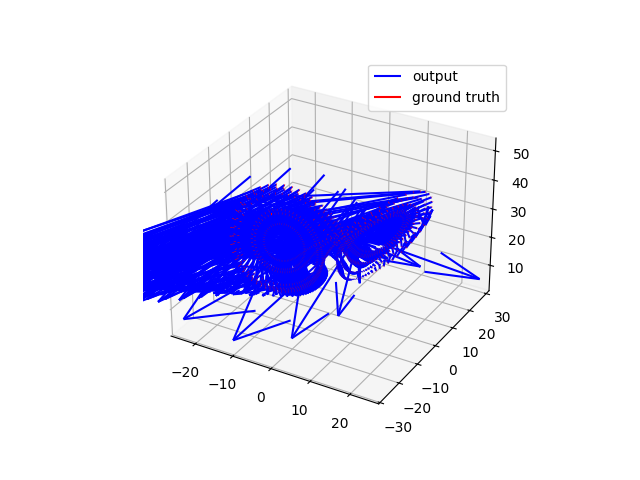

In [99]:
from mpl_toolkits.mplot3d import axes3d

fig = plt.figure()
ax = fig.add_subplot(projection="3d")

x = xyz[0]
y = xyz[1]
z = xyz[2]

dx_out = out[0]
dy_out = out[1]
dz_out = out[2]

dx_gt = dxyz[0]
dy_gt = dxyz[1]
dz_gt = dxyz[2]

ax.quiver(x, y, z, dx_out, dy_out, dz_out, length=.0005, color="blue", label="output")
ax.quiver(x, y, z, dx_gt, dy_gt, dz_gt, length=.0005, color="red", label="ground truth")

ax.set_xbound(x.min()-10,x.max()+10)
ax.set_ybound(y.min()-10,y.max()+10)
ax.set_zbound(z.min()-10,z.max()+10)

plt.legend()

In [82]:
plt.close()